# Visualise targets for simulation

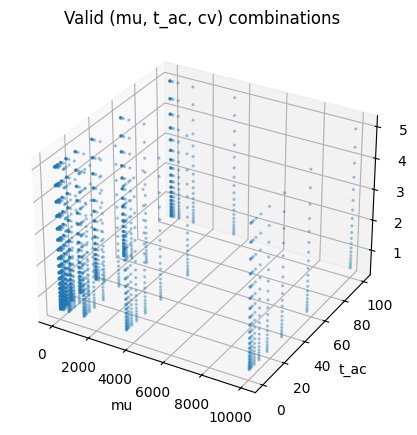

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
# Load the full grid of verified targets
mu_target = np.logspace(0, 4, 10)  # 1 to 10000
t_ac_target = np.logspace(-0.3, 2, 10)  # ~0.5 to 100
cv_target = np.logspace(-0.3, 0.7, 20)  # ~0.5 to 5
targets = np.array(np.meshgrid(mu_target, t_ac_target, cv_target)).T.reshape(-1, 3)

# Create a 3D scatter plot of mu vs t_ac vs cv
fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(targets[:, 0], targets[:, 1], targets[:, 2], s=2, alpha=0.3)
ax.set_xlabel('mu')
ax.set_ylabel('t_ac')
ax.set_zlabel('cv')
ax.set_title('Valid (mu, t_ac, cv) combinations')
plt.show()


CV values range from 0.50 to 5.01.


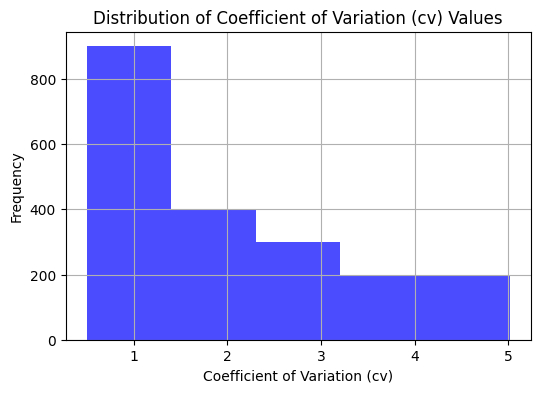

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
df_targets = pd.DataFrame(targets, columns=['mu', 't_ac', 'cv'])
# what ranges of CV values are chosen? 
cv_min = df_targets['cv'].min()
cv_max = df_targets['cv'].max()
print(f"CV values range from {cv_min:.2f} to {cv_max:.2f}.")
# plot the distribution of cv values chosen
plt.figure(figsize=(6, 4))
plt.hist(df_targets['cv'], bins=5, color='blue', alpha=0.7)
plt.xlabel('Coefficient of Variation (cv)')
plt.ylabel('Frequency')
plt.title('Distribution of Coefficient of Variation (cv) Values')
plt.grid()  
plt.show()

mu values range from 1.00 to 10000.00.


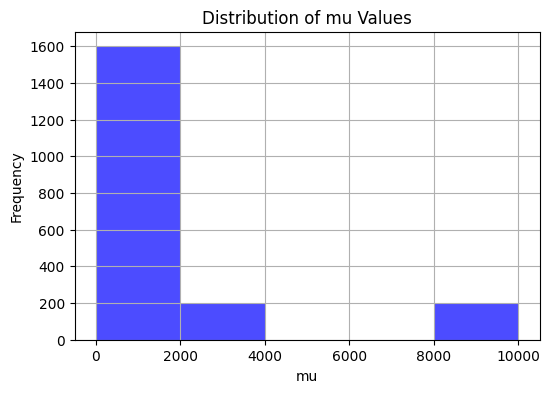

In [3]:
mu_min = df_targets['mu'].min()
mu_max = df_targets['mu'].max()
print(f"mu values range from {mu_min:.2f} to {mu_max:.2f}.")
# plot the distribution 
plt.figure(figsize=(6, 4))
plt.hist(df_targets['mu'], bins=5, color='blue', alpha=0.7)
plt.xlabel('mu')
plt.ylabel('Frequency')
plt.title('Distribution of mu Values')
plt.grid()  
plt.show()

t_ac values range from 0.50 to 100.00.


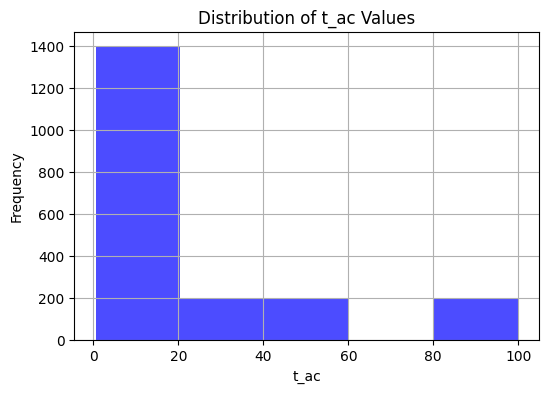

In [4]:
t_ac_min = df_targets['t_ac'].min()
t_ac_max = df_targets['t_ac'].max()
print(f"t_ac values range from {t_ac_min:.2f} to {t_ac_max:.2f}.")
# plot the distribution 
plt.figure(figsize=(6, 4))
plt.hist(df_targets['t_ac'], bins=5, color='blue', alpha=0.7)
plt.xlabel('t_ac')
plt.ylabel('Frequency')
plt.title('Distribution of t_ac Values')
plt.grid()  
plt.show()

In [5]:

import pandas as pd, numpy as np
from pathlib import Path
import sys
sys.path.append(str(Path().resolve().parents[1] / 'src'))
from stats.mean import calculate_mean
from stats.variance import calculate_variance
from stats.cv import calculate_cv
from stats.autocorrelation import autocrosscorr, calculate_ac_time_interp1d

data_dir = Path().resolve().parents[1] / 'data'
results_file = sorted(data_dir.glob('parameter_testing_results_*.csv'))[-1]
results = pd.read_csv(results_file)
results = results[results['success'] == True].reset_index(drop=True)
realized = []
for _, row in results.iterrows():
    traj = pd.read_csv(data_dir/row['trajectory_filename']).values
    param_set=[{'sigma_b': row['sigma_b'], 'sigma_u': row['sigma_u'], 'rho': row['rho'], 'd': row['d'], 'label':0}]
    mu_obs=calculate_mean(traj, param_set, use_steady_state=True)
    var_obs=calculate_variance(traj, param_set, use_steady_state=True)
    cv_obs=calculate_cv(var_obs, mu_obs)
    ac_vals,lags=autocrosscorr(traj, only_pos=True)
    ac_mean=np.nanmean(ac_vals, axis=0)
    t_ac_obs=calculate_ac_time_interp1d(ac_mean, lags)
    realized.append({'mu_calc':mu_obs, 'cv_calc':cv_obs, 't_ac_calc':float(t_ac_obs)})
realized_df=pd.DataFrame(realized)
combined=pd.concat([results[['mu_target','cv_target','t_ac_target']], realized_df], axis=1)
combined


,mu_target,cv_target,t_ac_target,mu_calc,cv_calc,t_ac_calc
0,10,1,1,10.177972,0.986759,1.089581


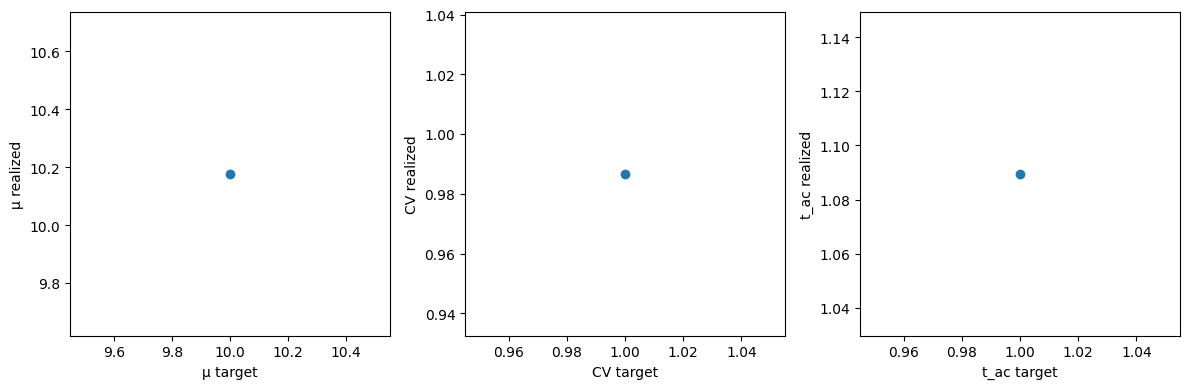

In [6]:

fig, axes = plt.subplots(1,3, figsize=(12,4))
axes[0].scatter(combined['mu_target'], combined['mu_calc'])
axes[0].set_xlabel('μ target'); axes[0].set_ylabel('μ realized')
axes[1].scatter(combined['cv_target'], combined['cv_calc'])
axes[1].set_xlabel('CV target'); axes[1].set_ylabel('CV realized')
axes[2].scatter(combined['t_ac_target'], combined['t_ac_calc'])
axes[2].set_xlabel('t_ac target'); axes[2].set_ylabel('t_ac realized')
plt.tight_layout()
plt.show()
